In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import OrderedDict 
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import normalize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
nltk.download('wordnet')
import re
import string
nltk.download('stopwords')
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df_1= pd.read_csv('/content/gdrive/My Drive/Classroom/dataset/training_variants') 
df_2= pd.read_csv('/content/gdrive/My Drive/Classroom/dataset/training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1,index_col=0) 

In [ ]:
df_1.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
#merging both gene_variations and text data based on ID
data = pd.merge(df_1, df_2, on='ID', how='left')
data.head() 

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
print('~> Total number of ene_variations:   {}'.format(len(data)))  

~> Total number of ene_variations:   3321


In [ ]:
#Checking whether there are any rows with null values
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [ ]:
data.loc[data['TEXT'].isnull(),'TEXT'] = data['Gene'] +' '+ data['Variation'] # Replace missing text with it Gene and Variation

7    0.286962
4    0.206564
1    0.171033
2    0.136104
6    0.082806
5    0.072870
3    0.026799
9    0.011141
8    0.005721
Name: Class, dtype: float64


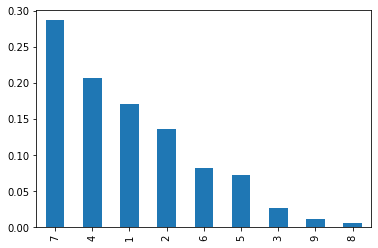

In [ ]:
print(data.Class.value_counts(normalize=True)) # balanced-dataset vs imbalanced datasets# 
plt.show(data.Class.value_counts(normalize=True).plot.bar()) #D istribution of data points among output classes 

In [ ]:
data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


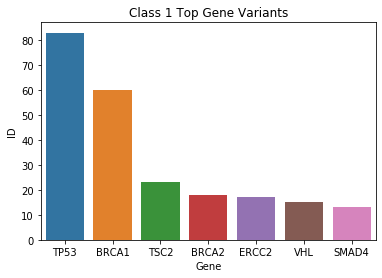

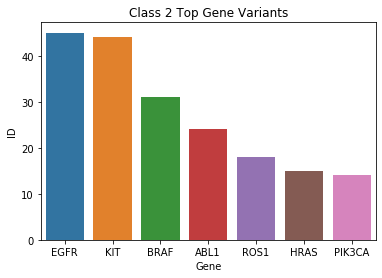

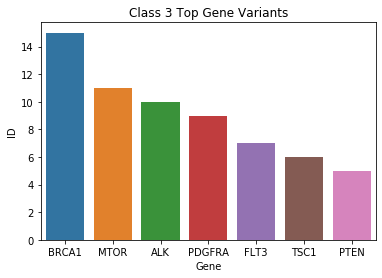

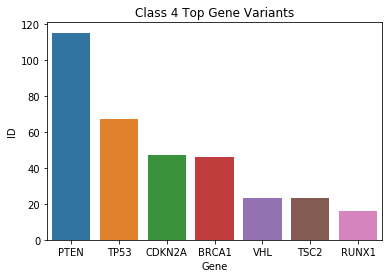

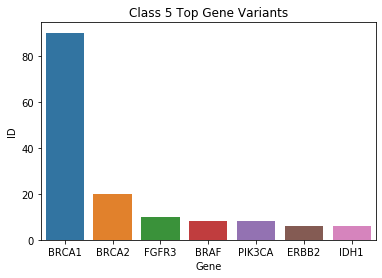

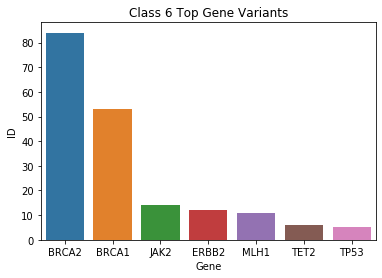

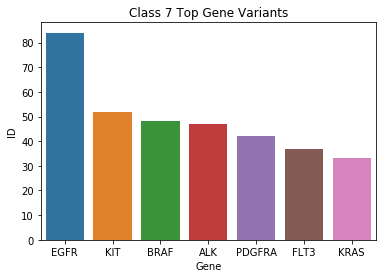

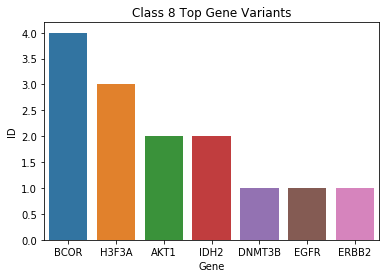

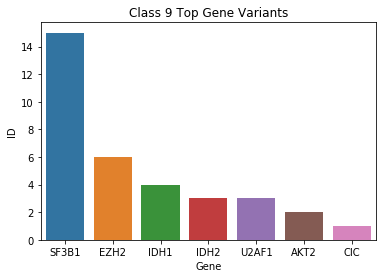

In [ ]:
for i in range(1,10):
    df= data[data['Class'] == i].groupby('Gene')["ID"].count().reset_index()
    sorted_gene_group = df.sort_values('ID', ascending=False)
    sns.barplot(x="Gene", y="ID", data=sorted_gene_group[:7]).set_title('Class {} Top Gene Variants'.format(i)) 
    plt.show() 

Some points we can conclude from these graphs:

BRCA1 is highly dominating Class 5

SF3B1 is highly dominating Class 9

BRCA1 and BRCA2 are dominating Class 6

EGFR and KIT are dominating Class 7

In [ ]:
STOP_WORDS = stopwords.words("english") 
lm= nltk.WordNetLemmatizer()
def preprocess(text):
  text= BeautifulSoup(text, 'lxml').get_text() 
  text = re.sub(r'[\(\[].*?[\)\]]',' ',text) #remove words inside brackets
  text = re.sub('(?:\s)Fig.[^, ]+', '',text) # Remove word Fig from text 
  text = re.sub('(?:\s)Table.[^, ]+', '',text) # Remove word Table from text
  text = re.sub(r'^[0-9]+$', ' ', text)
  text = re.sub(r'-+[0-9]{2,}', ' ', text)
  text = re.sub(r'[0-9]{2,}', ' ', text)
  text = re.sub(r'[»⇓âåâ→°¶¢—•*~∑]+', ' ', text)
  text= re.sub(r'[-]{2,}', ' ',text)
  text= re.sub(r'[-]{2,}.[-]{2,}', ' ',text)
  a =  string.punctuation.replace('-', ' ')
  text = re.sub(r'[{}]'.format(a),' ', text) # Remove  punctuation  
  #text = ' '.join(word for word in text.split() if not word.isdigit()) 
  text = re.sub(r'\d+.\d+', ' ', text)
  text = re.sub("\s\s+" , " ", text)
  text = text.lower()
  text = ' '.join(word for word in text.split() if len(word)>3)
  text = text.split()
  STOP_WORDS = stopwords.words("english") 
  text = list(OrderedDict.fromkeys([word for word in text if word not in STOP_WORDS]))
  # text = [lm.lemmatize(word) for word in text]
  return text 

In [ ]:
data['cleantext'] = data['TEXT'].apply(lambda x: preprocess(x))

In [ ]:
def lemmatizer(text):
    text = [lm.lemmatize(word) for word in text]
    return text 
data['Text_lemmatized'] = data['cleantext'].apply(lambda x: lemmatizer(x))
data.head() 

,ID,Gene,Variation,Class,TEXT,cleantext,Text_lemmatized
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,"[cyclin-dependent, kinases, regulate, variety,...","[cyclin-dependent, kinase, regulate, variety, ..."
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,"[abstract, background, non-small, cell, lung, ...","[abstract, background, non-small, cell, lung, ..."
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,"[abstract, background, non-small, cell, lung, ...","[abstract, background, non-small, cell, lung, ..."
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,"[recent, evidence, demonstrated, acquired, uni...","[recent, evidence, demonstrated, acquired, uni..."
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,"[oncogenic, mutations, monomeric, casitas, b-l...","[oncogenic, mutation, monomeric, casitas, b-li..."


In [ ]:
data.Gene      = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_') 

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(['TEXT','ID'],axis=1) 
Y = data['Class'] 
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify= Y]
X_train,X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)  
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column 
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [1]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = X_test.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.470159705671405
Log loss on Test Data using Random Model 2.413729831962691


In [ ]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = df[feature].value_counts()
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)] 
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict
# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = df[feature].value_counts()
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

- **Univariate Analysis on Gene Feature**

   - Response variable encoding technique

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df)) 
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene",X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [ ]:
from sklearn.preprocessing import normalize
train_gene_feature_responseCoding = normalize(train_gene_feature_responseCoding,axis=0, copy=False)
test_gene_feature_responseCoding =  normalize(test_gene_feature_responseCoding,axis=0, copy=False)
cv_gene_feature_responseCoding = normalize(cv_gene_feature_responseCoding,axis=0,copy=False)  

- Feature Hashing Scheme

In [ ]:
# instead of using one hot encoding, i used Feature Hashing Scheme  for gene feature 
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=9, input_type='string') 
Train_gene_hashed_features = normalize(np.array((fh.fit_transform(train_df['Gene'])).toarray()))
Test_gene_hashed_features = normalize(np.array((fh.transform(X_test['Gene'])).toarray())) 
cv_gene_hashed_features = normalize(np.array((fh.transform(cv_df['Gene'])).toarray())) 

- How good is this gene feature in predicting y_i

For values of alpha =  1e-05 The log loss is: 1.7233170008960328
For values of alpha =  0.0001 The log loss is: 1.7073462247336906
For values of alpha =  0.001 The log loss is: 1.7067019318645515
For values of alpha =  0.01 The log loss is: 1.7120301875507435
For values of alpha =  0.1 The log loss is: 1.7233539852616266
For values of alpha =  1 The log loss is: 1.7586557705423116


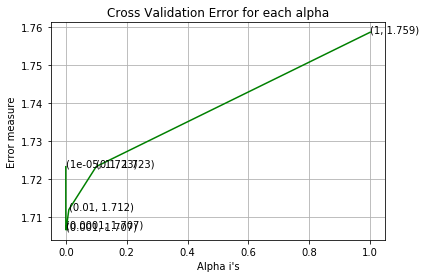

For values of best alpha =  0.001 The train log loss is: 1.6619622089663058
For values of best alpha =  0.001 The cross validation log loss is: 1.7067019318645515
For values of best alpha =  0.001 The test log loss is: 1.6447338673448721


In [ ]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) 
    clf.fit(Train_gene_hashed_features, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Train_gene_hashed_features, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_hashed_features)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(Train_gene_hashed_features, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(Train_gene_hashed_features, y_train)

predict_y = sig_clf.predict_proba(Train_gene_hashed_features)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_hashed_features)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(Test_gene_hashed_features)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.377566926066242
For values of alpha =  0.0001 The log loss is: 1.4459002571413362
For values of alpha =  0.001 The log loss is: 1.4510665878787952
For values of alpha =  0.01 The log loss is: 1.5465986486096992
For values of alpha =  0.1 The log loss is: 1.758380800400528
For values of alpha =  1 The log loss is: 5.663765240968673


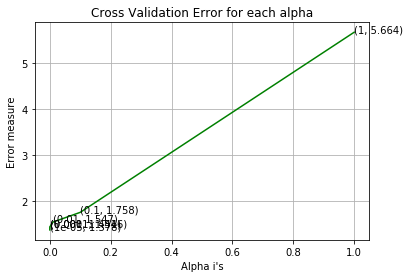

For values of best alpha =  1e-05 The train log loss is: 1.2377206800198837
For values of best alpha =  1e-05 The cross validation log loss is: 1.377566926066242
For values of best alpha =  1e-05 The test log loss is: 1.2322638984539382


In [ ]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) 
    clf.fit(train_gene_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
print("How many data points in Test and CV datasets are covered by the ", train_df['Gene'].value_counts().shape[0], " genes in train dataset?")
test_coverage=X_test[X_test['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

How many data points in Test and CV datasets are covered by the  229  genes in train dataset?
Ans
1. In test data 639 out of 665 : 96.09022556390977
2. In cross validation data 513 out of  532 : 96.42857142857143


- **Univariate Analysis on Variation Feature**

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_var_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation",train_df))
# test gene feature
test_var_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation",X_test)) 
# cross validation
cv_var_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation",cv_df))  

In [ ]:
train_var_feature_responseCoding = normalize(train_var_feature_responseCoding,axis=0, copy=False) 
test_var_feature_responseCoding =  normalize(test_var_feature_responseCoding,axis=0, copy=False) 
cv_var_feature_responseCoding = normalize(cv_var_feature_responseCoding,axis=0,copy=False)

In [ ]:
# instead of using one hot encoding, i used Feature Hashing Scheme  for gene feature 
fh = FeatureHasher(n_features=9, input_type='string')  
Train_var_hashed_features = normalize(np.array((fh.fit_transform(train_df['Variation'])).toarray()) )
Test_var_hashed_features = normalize(np.array((fh.transform(X_test['Variation'])).toarray()))  
cv_var_hashed_features =   normalize(np.array((fh.transform(cv_df['Variation'])).toarray())) 

For values of alpha =  1e-05 The log loss is: 1.730890985119268
For values of alpha =  0.0001 The log loss is: 1.7140317322806828
For values of alpha =  0.001 The log loss is: 1.7031426390176758
For values of alpha =  0.01 The log loss is: 1.7506419714260033
For values of alpha =  0.1 The log loss is: 1.7618433864077507
For values of alpha =  1 The log loss is: 8.315442528608632


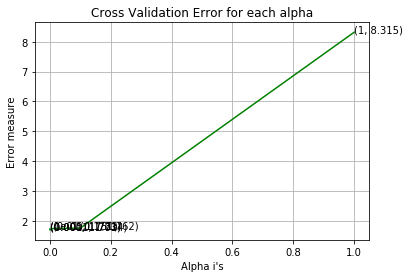

For values of best alpha =  0.001 The train log loss is: 0.8351021769302235
For values of best alpha =  0.001 The cross validation log loss is: 1.7031426390176758
For values of best alpha =  0.001 The test log loss is: 1.7756921149069838


In [ ]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) 
    clf.fit(train_var_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_var_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_var_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_var_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_var_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_var_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_var_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_var_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
print("How many data points in Test are covered by the ",X_train['Variation'].value_counts().shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0] 

print('In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100) 

How many data points in Test are covered by the  2420  genes in train dataset?
In test data 84 out of 665 : 12.631578947368421


- Gene feature with Response encoding technique giving good log-loss when you comparing with Feature Hashing Scheme on gene feature. 

- Variation feature with Response encoding technique giving good log-loss when you comparing with Feature Hashing Scheme on Variation feature. 

In [ ]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer(max_features = 5000, analyzer= clean_text)
    var_count_vec = TfidfVectorizer(max_features = 5000,analyzer= clean_text)
    text_count_vec = TfidfVectorizer(min_df=3,max_features = 5000,analyzer= clean_text) 
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text_lemmatized'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in str(text).split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

**Text Feature**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# finding TFIDF for Text
def clean_text(text):
  return text
tfidf = TfidfVectorizer(min_df=5, max_features =5000,analyzer= clean_text, strip_accents='unicode',ngram_range= (1,2), use_idf= 1, smooth_idf= 1,sublinear_tf= 1)

In [ ]:
# we use the same vectorizer
train_text_feature_onehotCoding =  tfidf.fit_transform(train_df['Text_lemmatized'])
train_text_features= tfidf.get_feature_names()
test_text_feature_onehotCoding  =  tfidf.transform(X_test['Text_lemmatized'])
cv_text_feature_onehotCoding    =  tfidf.transform(cv_df['Text_lemmatized']) 
# don't forget to normalize every feature 
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0,copy=False)
test_text_feature_onehotCoding =  normalize(test_text_feature_onehotCoding, axis=0,copy=False)
cv_text_feature_onehotCoding =    normalize(cv_text_feature_onehotCoding, axis=0,copy=False) 

In [ ]:
from collections import Counter, defaultdict
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in str(row['Text_lemmatized']).split():
            dictionary[word] +=1
    return dictionary

In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)
confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
      row_index = 0
      for index, row in df.iterrows():
        sum_prob = 0
        for word in row['Text_lemmatized']:
          sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
        text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(str(row['Text_lemmatized']).split()))
        row_index += 1
    return text_feature_responseCoding 

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

**Stacking the three types of features**

In [ ]:
train_x_onehotCoding = hstack((Train_gene_hashed_features,Train_var_hashed_features,train_text_feature_onehotCoding)).tocsr()
train_y = np.array(y_train) 

test_x_onehotCoding = hstack((Test_gene_hashed_features,Test_var_hashed_features,test_text_feature_onehotCoding)).tocsr()
test_y = np.array(y_test) 

cv_x_onehotCoding = hstack((cv_gene_hashed_features,cv_var_hashed_features,cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(y_cv) 

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 5018)
(number of data points * number of features) in test data =  (665, 5018)
(number of data points * number of features) in cross validation data = (532, 5018)


In [ ]:
train_x_responseCoding = np.hstack((train_gene_feature_responseCoding, train_var_feature_responseCoding,train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_feature_responseCoding, test_var_feature_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_var_feature_responseCoding,cv_text_feature_responseCoding))

In [ ]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape) 
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


##Naive Bayes(Base Model)

for alpha = 1e-05
Log Loss : 1.364437971013
for alpha = 0.0001
Log Loss : 1.3663620325861567
for alpha = 0.001
Log Loss : 1.387989724153328
for alpha = 0.1
Log Loss : 2.6594706681121996
for alpha = 1
Log Loss : 3.494502294685308
for alpha = 10
Log Loss : 6.489271509069276
for alpha = 100
Log Loss : 9.128133849564712
for alpha = 1000
Log Loss : 9.77237834809355


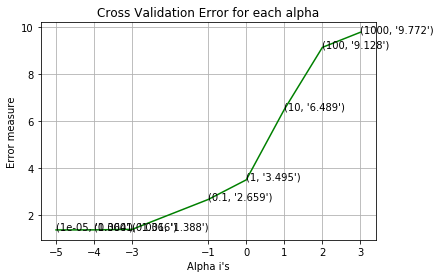

For values of best alpha =  1e-05 The train log loss is: 1.2327604652292492
For values of best alpha =  1e-05 The cross validation log loss is: 1.364437971013
For values of best alpha =  1e-05 The test log loss is: 1.2253079516578904


In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)
predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss : 1.364437971013
Number of missclassified point : 0.45864661654135336
-------------------- Confusion matrix --------------------


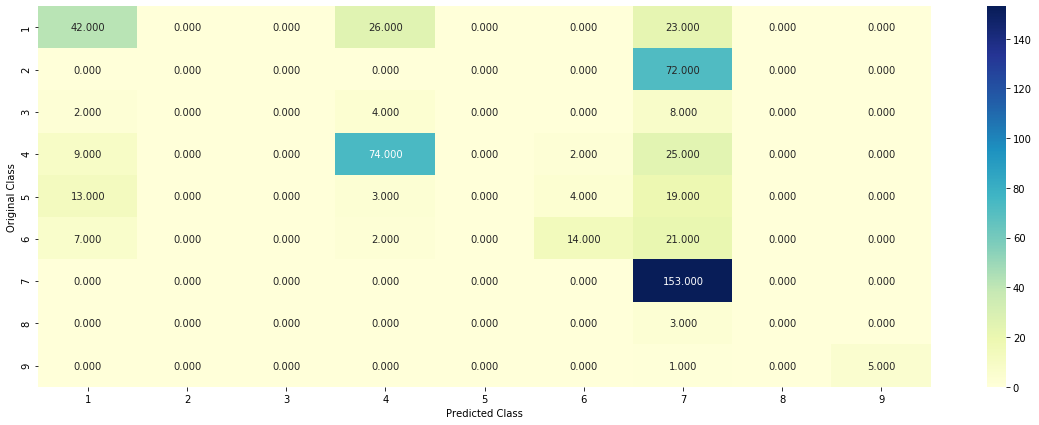

-------------------- Precision matrix (Columm Sum=1) --------------------


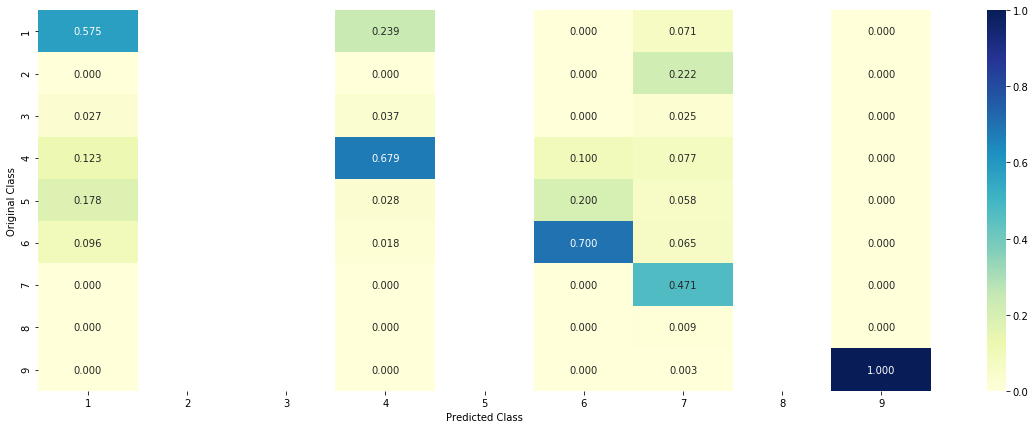

-------------------- Recall matrix (Row sum=1) --------------------


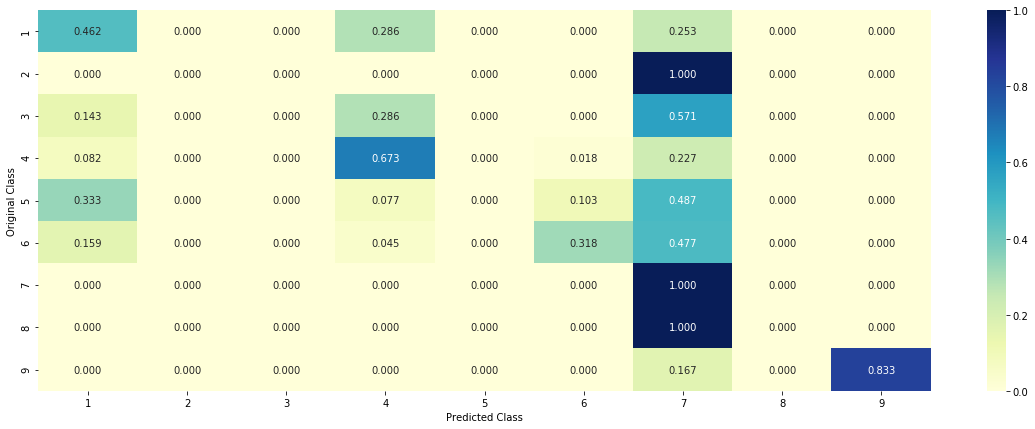

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_responseCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_responseCoding)) 

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1, -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0],X_test['Text_lemmatized'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6171 0.0579 0.0104 0.1195 0.0376 0.0334 0.0986 0.0114 0.0141]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


##K Nearest Neighbour Classification

for alpha = 5
Log Loss : 1.0768832293134452
for alpha = 11
Log Loss : 0.8984857744953403
for alpha = 15
Log Loss : 0.8830847940188399
for alpha = 21
Log Loss : 0.864341359160592
for alpha = 31
Log Loss : 0.8698938526871388
for alpha = 41
Log Loss : 0.949934593830327
for alpha = 51
Log Loss : 0.9912387384223474
for alpha = 99
Log Loss : 1.2062997676173135


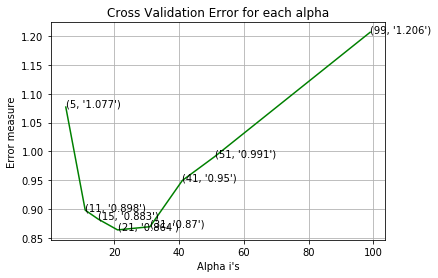

For values of best alpha =  21 The train log loss is: 0.548507290003712
For values of best alpha =  21 The cross validation log loss is: 0.864341359160592
For values of best alpha =  21 The test log loss is: 0.6436060815980039


In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.864341359160592
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


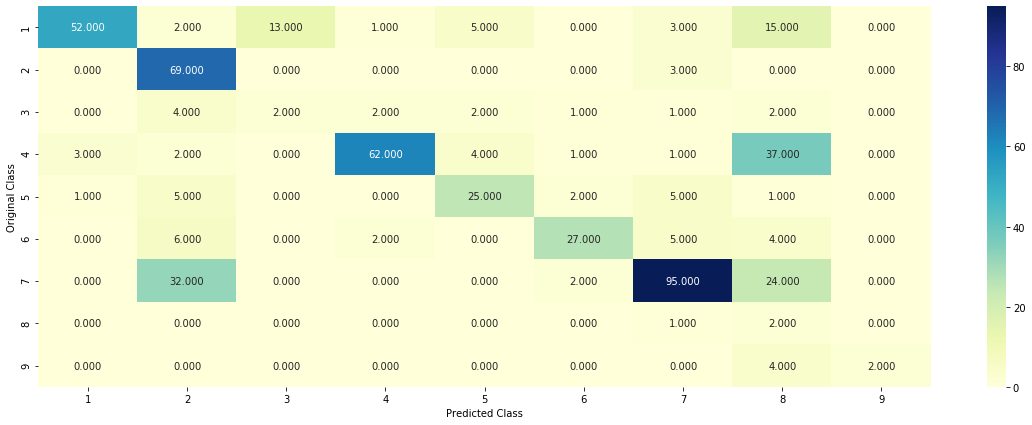

-------------------- Precision matrix (Columm Sum=1) --------------------


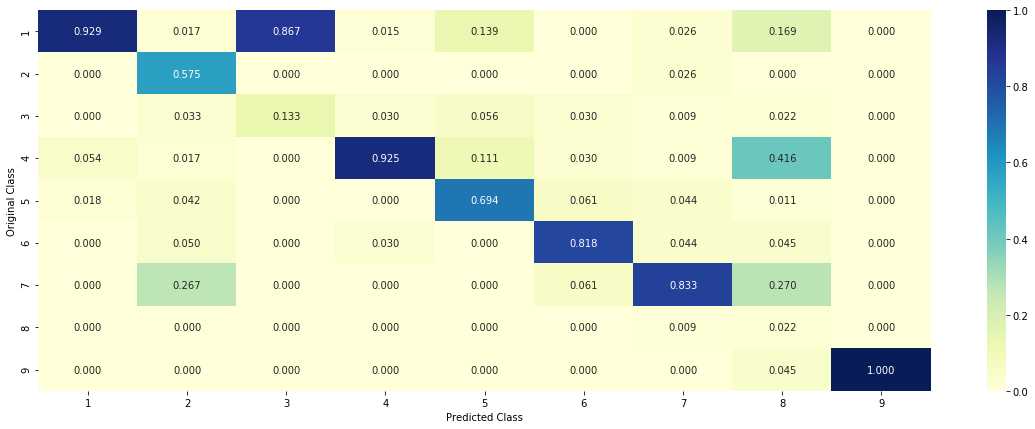

-------------------- Recall matrix (Row sum=1) --------------------


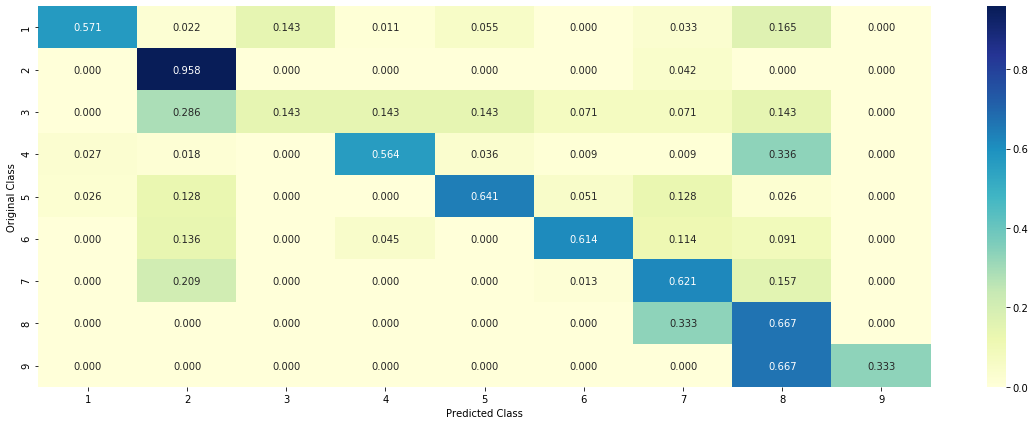

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 21 and the nearest neighbours of the test points belongs to classes [4 9 4 4 3 3 4 4 4 4 4 4 4 1 3 1 1 4 4 2 4]
Fequency of nearest points : Counter({4: 13, 3: 3, 1: 3, 9: 1, 2: 1})


## Logistic Regression

for alpha = 1e-06
Log Loss : 1.1985353927257303
for alpha = 1e-05
Log Loss : 1.1980727106140245
for alpha = 0.0001
Log Loss : 1.2238096564882943
for alpha = 0.001
Log Loss : 1.2319256313549118
for alpha = 0.01
Log Loss : 1.3259343270882367
for alpha = 0.1
Log Loss : 1.6747505723231029
for alpha = 1
Log Loss : 1.8270769467092025
for alpha = 10
Log Loss : 1.8467688132079059
for alpha = 100
Log Loss : 1.8487951786593277


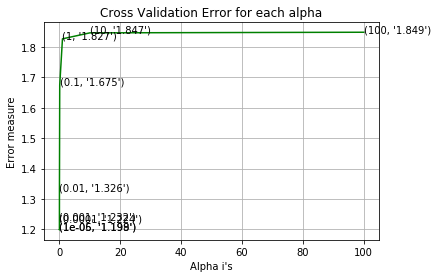

For values of best alpha =  1e-05 The train log loss is: 0.5544138400102008
For values of best alpha =  1e-05 The cross validation log loss is: 1.1980727106140245
For values of best alpha =  1e-05 The test log loss is: 1.1287287482119335


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1980727106140245
Number of mis-classified points : 0.39849624060150374
-------------------- Confusion matrix --------------------


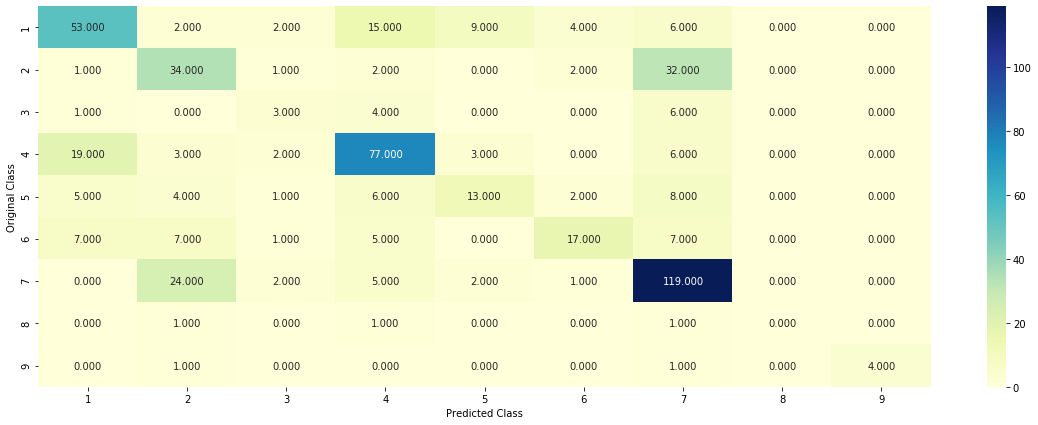

-------------------- Precision matrix (Columm Sum=1) --------------------


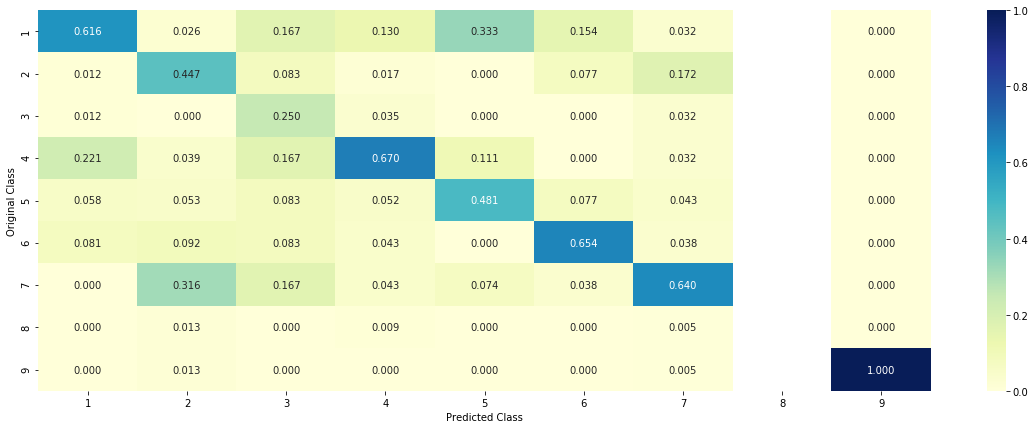

-------------------- Recall matrix (Row sum=1) --------------------


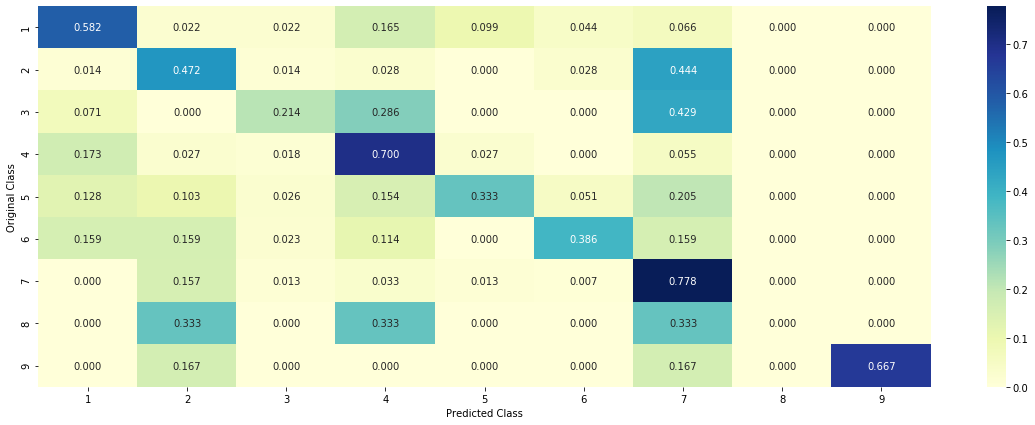

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0],X_test['Text_lemmatized'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0633 0.4807 0.0013 0.1084 0.0043 0.0213 0.3185 0.0017 0.0005]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point


**Linear Support Vector Machines**

for C = 1e-05
Log Loss : 1.2000377901592088
for C = 0.0001
Log Loss : 1.2395281612697753
for C = 0.001
Log Loss : 1.2955279493611622
for C = 0.01
Log Loss : 1.754530042697878
for C = 0.1
Log Loss : 1.738329748145496
for C = 1
Log Loss : 1.8482514594966326
for C = 10
Log Loss : 1.8490998625883228
for C = 100
Log Loss : 1.849103608786936


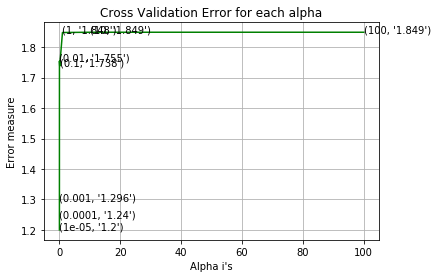

For values of best alpha =  1e-05 The train log loss is: 0.5873020289786961
For values of best alpha =  1e-05 The cross validation log loss is: 1.2000377901592088
For values of best alpha =  1e-05 The test log loss is: 1.1287940348905465


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2000377901592088
Number of mis-classified points : 0.39473684210526316
-------------------- Confusion matrix --------------------


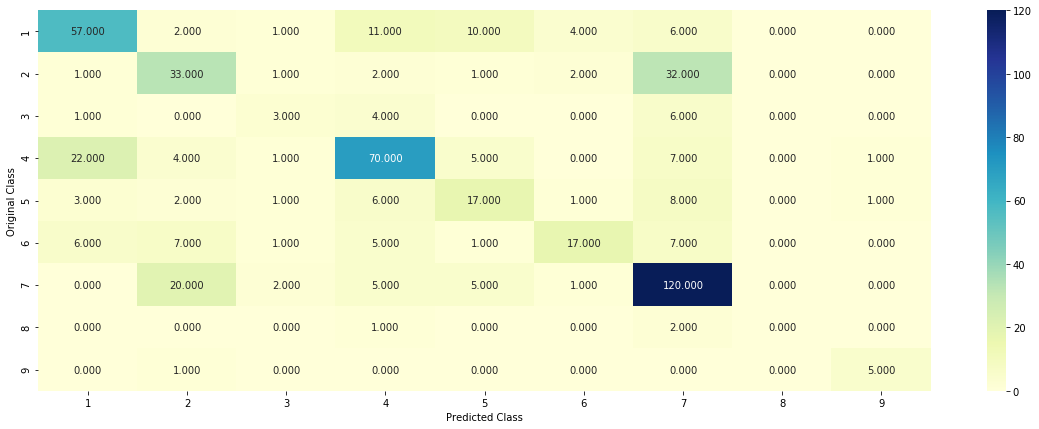

-------------------- Precision matrix (Columm Sum=1) --------------------


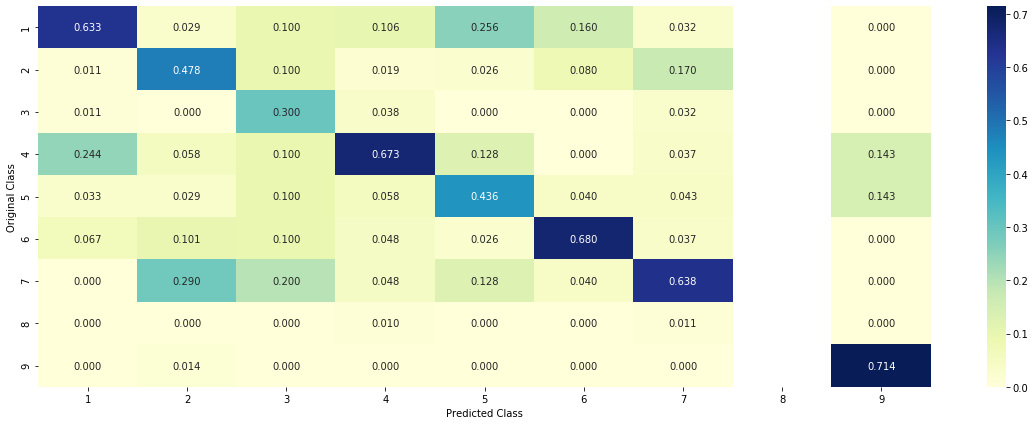

-------------------- Recall matrix (Row sum=1) --------------------


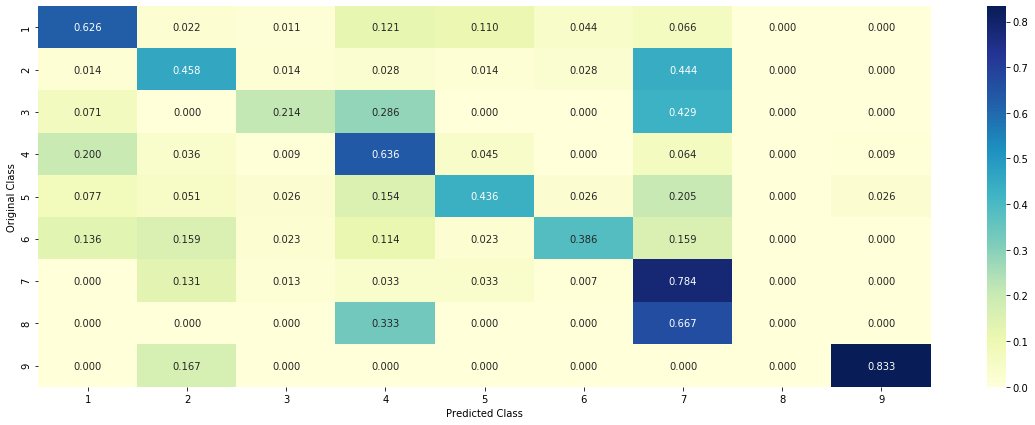

In [ ]:
# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf) 

In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 8
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0],X_test['Text_lemmatized'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[2.130e-02 2.560e-02 9.800e-03 9.710e-02 2.630e-02 1.700e-03 8.159e-01
  1.700e-03 7.000e-04]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


**Random Forest Classifier**

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.3070421404070622
for n_estimators = 100 and max depth =  10
Log Loss : 1.3028240992711466
for n_estimators = 200 and max depth =  5
Log Loss : 1.2923225171468506
for n_estimators = 200 and max depth =  10
Log Loss : 1.291729156567073
for n_estimators = 500 and max depth =  5
Log Loss : 1.2893053979710019
for n_estimators = 500 and max depth =  10
Log Loss : 1.2949146710537691
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2882559816307029
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2948932278465333
for n_estimators = 2000 and max depth =  5
Log Loss : 1.290094655300079
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2921028145137234
For values of best estimator =  1000 The train log loss is: 0.8639150145775782
For values of best estimator =  1000 The cross validation log loss is: 1.288255981630703
For values of best estimator =  1000 The test log loss is: 1.227004271760934


Log loss : 1.288255981630703
Number of mis-classified points : 0.4417293233082707
-------------------- Confusion matrix --------------------


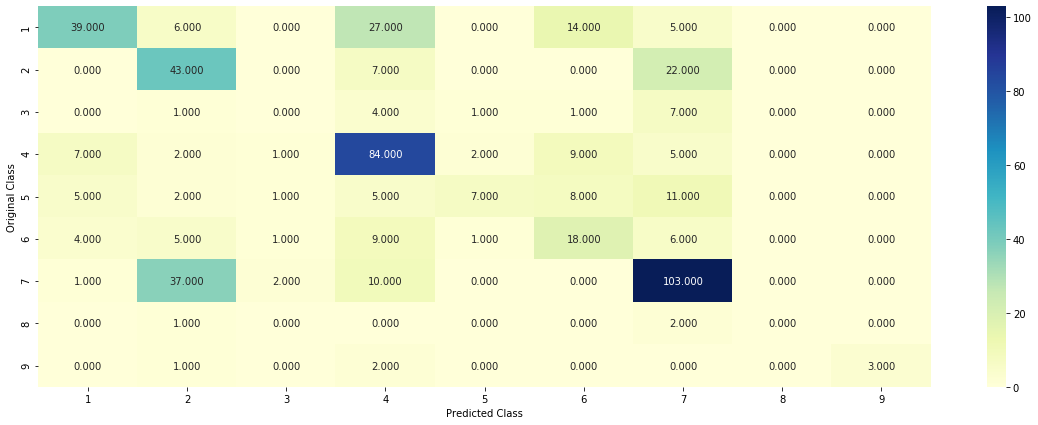

-------------------- Precision matrix (Columm Sum=1) --------------------


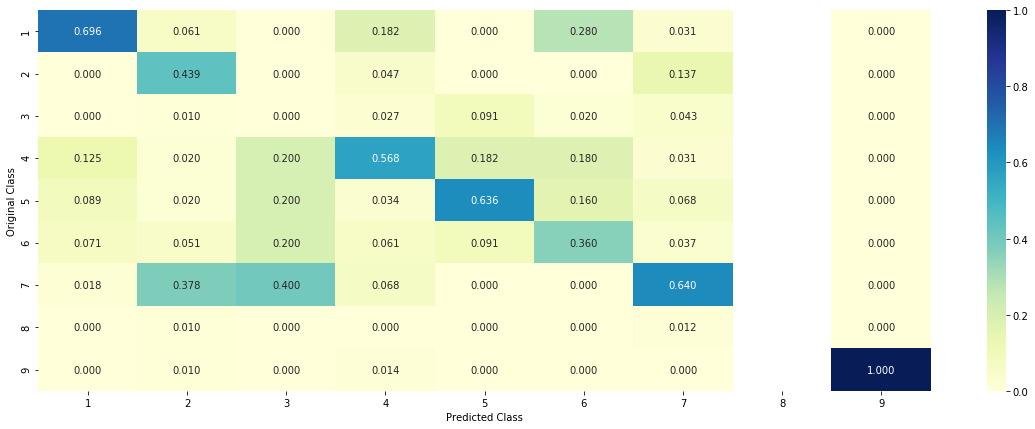

-------------------- Recall matrix (Row sum=1) --------------------


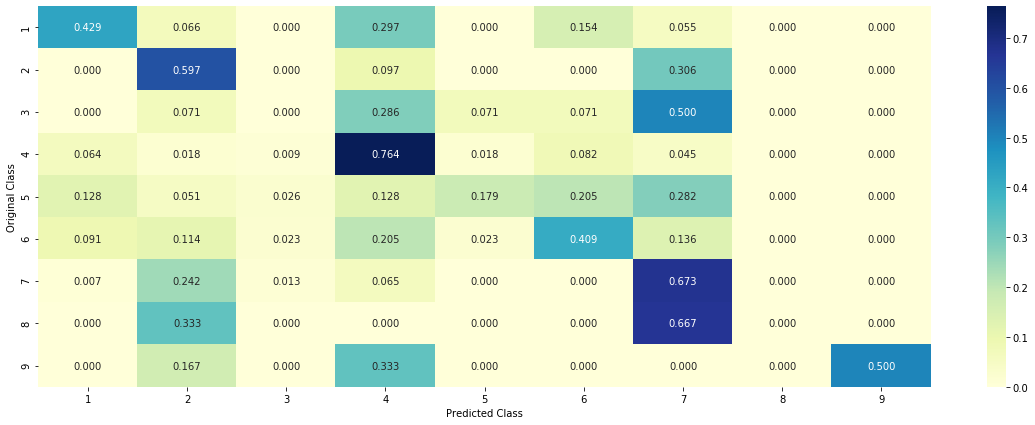

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [ ]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['Text_lemmatized'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0416 0.5576 0.0125 0.0262 0.0445 0.0562 0.2563 0.0028 0.0023]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


**RF_ Hyper paramter tuning (With Response Coding)**

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 4.84517744039578
for n_estimators = 10 and max depth =  3
Log Loss : 3.306200316583632
for n_estimators = 10 and max depth =  5
Log Loss : 2.505721184177838
for n_estimators = 10 and max depth =  10
Log Loss : 2.0288580870353625
for n_estimators = 50 and max depth =  2
Log Loss : 3.7143185901372466
for n_estimators = 50 and max depth =  3
Log Loss : 2.0044443519545836
for n_estimators = 50 and max depth =  5
Log Loss : 1.9098906853154176
for n_estimators = 50 and max depth =  10
Log Loss : 1.8765350609114948
for n_estimators = 100 and max depth =  2
Log Loss : 3.1969239990828195
for n_estimators = 100 and max depth =  3
Log Loss : 2.434366900467641
for n_estimators = 100 and max depth =  5
Log Loss : 1.8843768705845503
for n_estimators = 100 and max depth =  10
Log Loss : 1.8642110146068602
for n_estimators = 200 and max depth =  2
Log Loss : 3.2002841351530344
for n_estimators = 200 and max depth =  3
Log Loss : 2.183960646498438
for

Log loss : 1.8480714769341418
Number of mis-classified points : 0.7124060150375939
-------------------- Confusion matrix --------------------


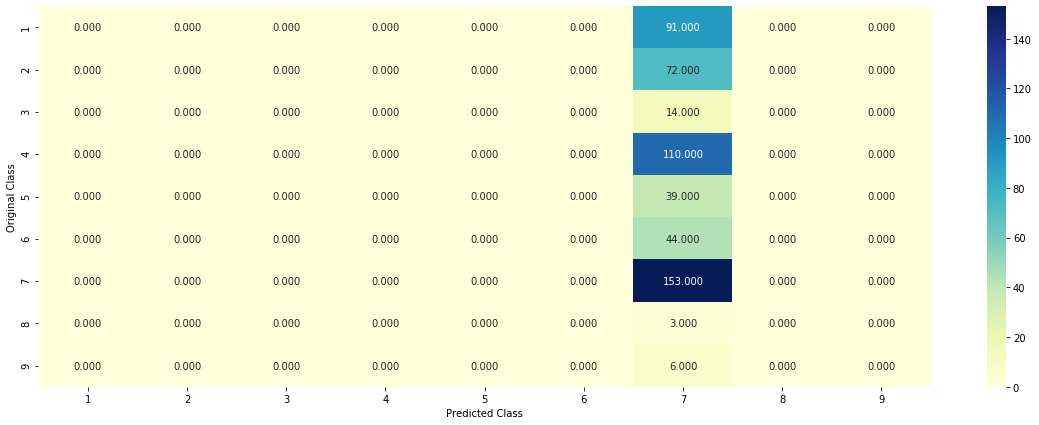

-------------------- Precision matrix (Columm Sum=1) --------------------


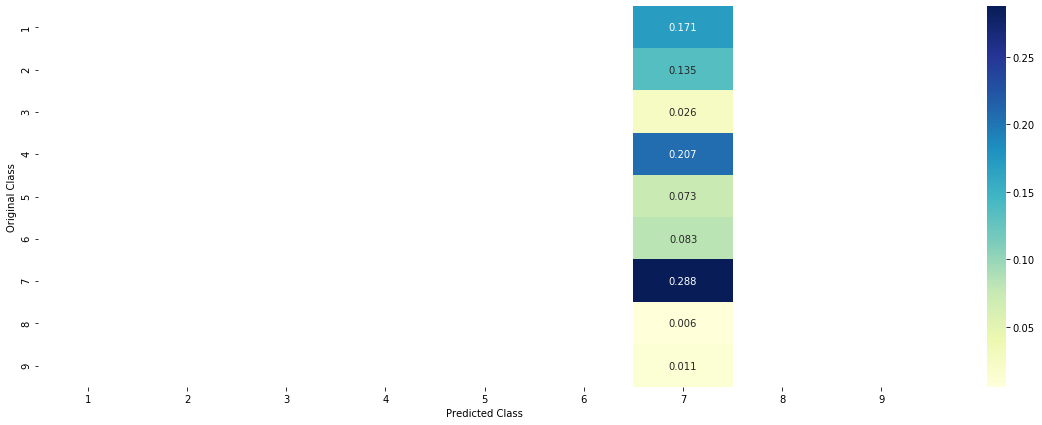

-------------------- Recall matrix (Row sum=1) --------------------


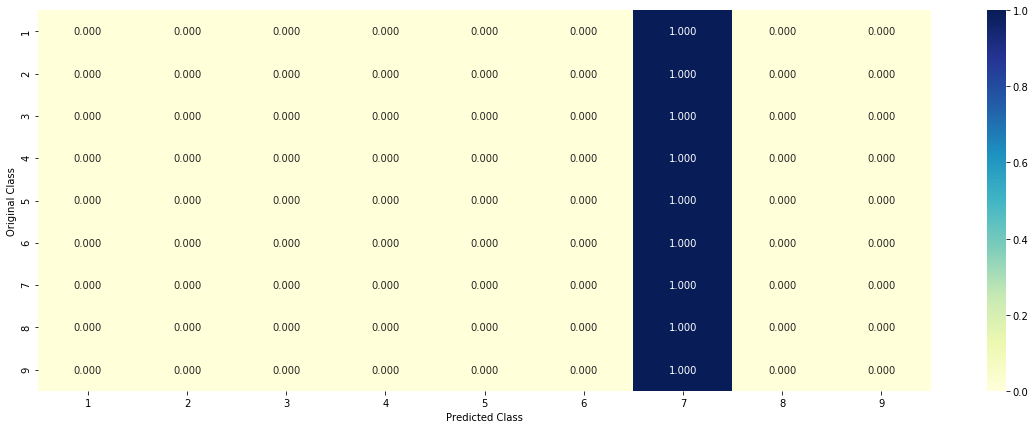

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.1749 0.1312 0.0271 0.2219 0.0442 0.0888 0.273  0.0199 0.019 ]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature


**Stack the models**

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = KNeighborsClassifier(n_neighbors=5)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
sig_clf3.fit(train_x_onehotCoding, train_y)

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding)))) 
sig_clf2.fit(train_x_onehotCoding, train_y)
print("KNeighbors : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2,sig_clf2], meta_classifier=lr, use_probas=True) 
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.23
Support vector machines : Log Loss: 1.85
KNeighbors : Log Loss: 1.21
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.823
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.766
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.457
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.216
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.452
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.663


Log loss (train) on the stacking classifier : 0.6617056205969062
Log loss (CV) on the stacking classifier : 1.3381467866154892
Log loss (test) on the stacking classifier : 1.1772429792917172
Number of missclassified point : 0.3684210526315789
-------------------- Confusion matrix --------------------


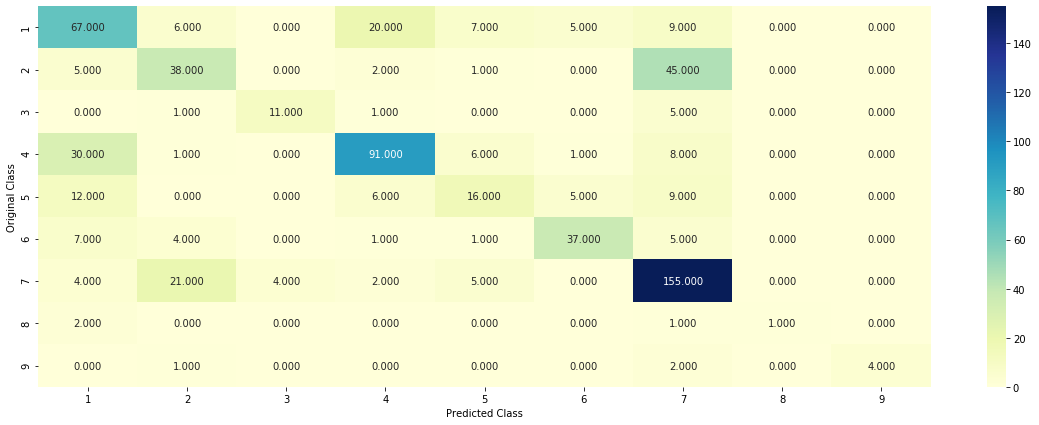

-------------------- Precision matrix (Columm Sum=1) --------------------


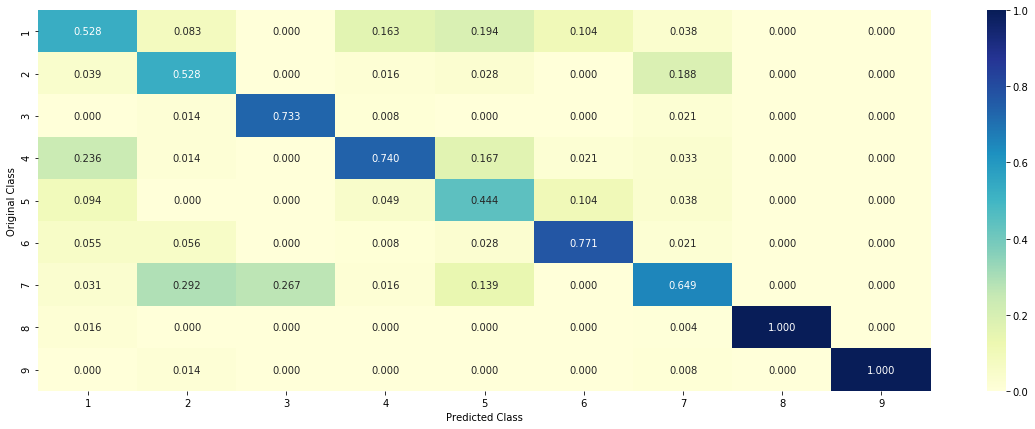

-------------------- Recall matrix (Row sum=1) --------------------


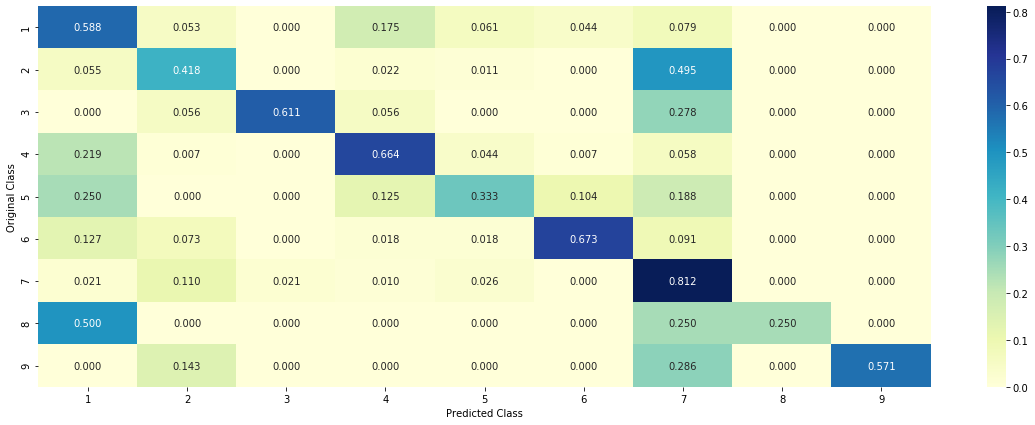

In [ ]:
lr = LogisticRegression(C=1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

**Majority Voting classifier**

Log loss (train) on the VotingClassifier : 1.0126134548010057
Log loss (CV) on the VotingClassifier : 1.2180179937346454
Log loss (test) on the VotingClassifier : 1.1229198094639783
Number of missclassified point : 0.3699248120300752
-------------------- Confusion matrix --------------------


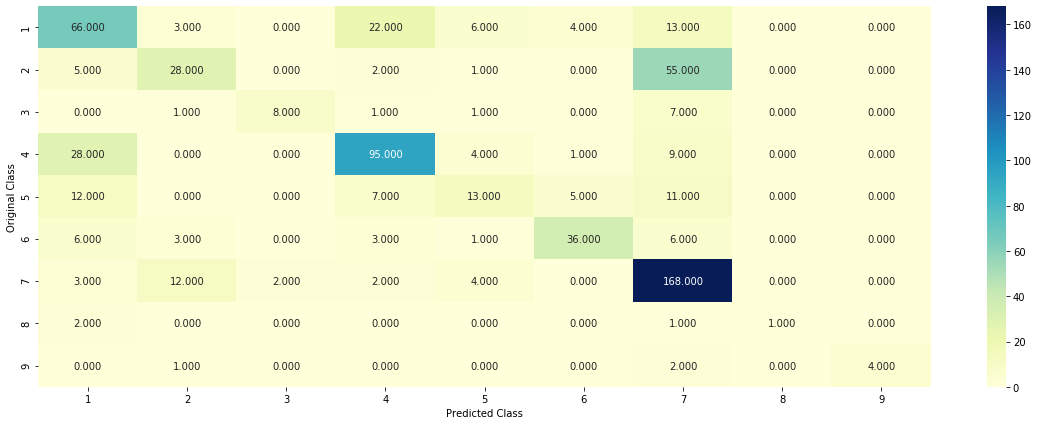

-------------------- Precision matrix (Columm Sum=1) --------------------


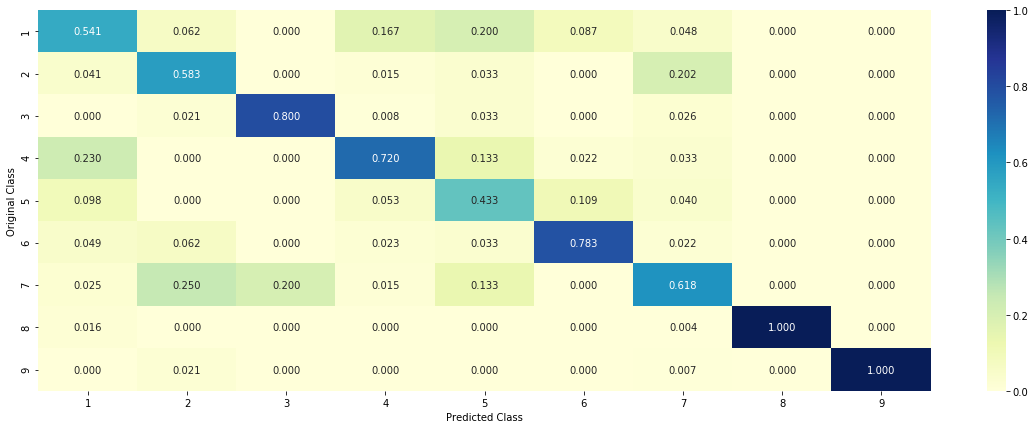

-------------------- Recall matrix (Row sum=1) --------------------


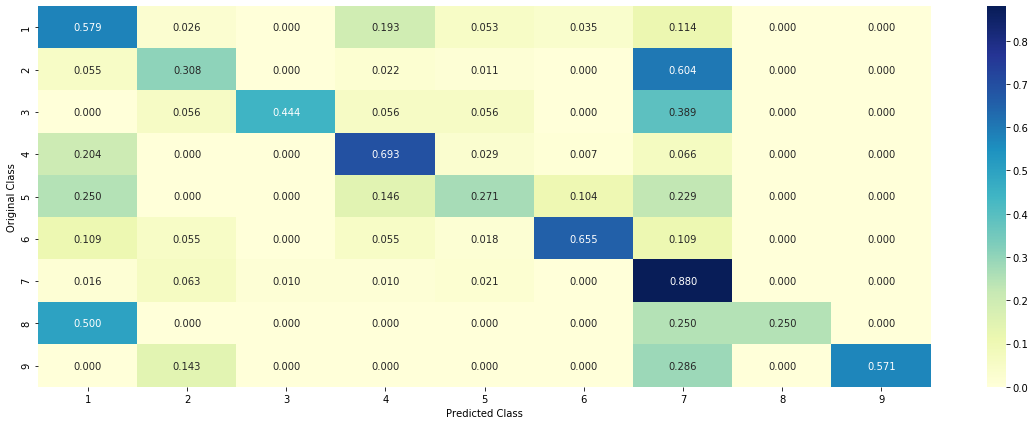

In [ ]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('knn', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

**Truncated-SVD for feature_engineering**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def clean_text(text):
  return text
tfidf = TfidfVectorizer(min_df=5, max_features =5000,analyzer= clean_text, strip_accents='unicode',ngram_range= (1,2), use_idf= 1, smooth_idf= 1,sublinear_tf= 1)
tfidf_train = tfidf.fit_transform (train_df['Text_lemmatized']) 

In [ ]:
tfidf_train_features= tfidf.get_feature_names() 
tfidf_test=  tfidf.transform(X_test['Text_lemmatized'])
tfidf_cv=  tfidf.transform(cv_df['Text_lemmatized'])

In [ ]:
from sklearn.decomposition import TruncatedSVD
n_components=[10,20,50,60,100,200,300,400,500,1000,1200,1500,2000]
var_explnd = []
# Get the explained_variance for each dimension in the 'dim'
for comps in n_components:
  model_svd = TruncatedSVD(n_components=comps)
  model_svd.fit_transform(tfidf_train)
  expvar=model_svd.explained_variance_ratio_.sum() 
  var_explnd.append(expvar)
  print('n_components=',comps,'Explained variance=',expvar)

n_components= 10 Explained variance= 0.1637631802211098
n_components= 20 Explained variance= 0.24288382220218613
n_components= 50 Explained variance= 0.37017943077749277
n_components= 60 Explained variance= 0.40032836546018147
n_components= 100 Explained variance= 0.49440362886350525
n_components= 200 Explained variance= 0.640877130856924
n_components= 300 Explained variance= 0.7309191605713385
n_components= 400 Explained variance= 0.795963691413814
n_components= 500 Explained variance= 0.8471839245577766
n_components= 1000 Explained variance= 0.9822345323750131
n_components= 1200 Explained variance= 0.9972341520832428
n_components= 1500 Explained variance= 1.0
n_components= 2000 Explained variance= 0.9999999999999998


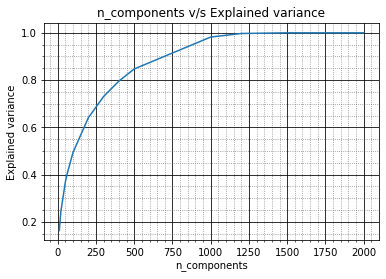

In [ ]:
#plotting curve between n_components and explained variance
plt.plot(n_components,var_explnd)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', color='black')
plt.grid(which='minor', linestyle=':', color='gray')
plt.xlabel('n_components')
plt.ylabel("Explained variance")
plt.title("n_components v/s Explained variance")
plt.show()

In [ ]:
svd = TruncatedSVD(n_components=1000)
tfidf_train_SVD= svd.fit_transform(tfidf_train)
tfidf_test_SVD= svd.transform(tfidf_test) 
tfidf_cv_SVD = svd.transform(tfidf_cv)
print (tfidf_train_SVD.shape) 
print (tfidf_test_SVD.shape) 
print (tfidf_cv_SVD.shape) 

(2124, 1000)
(665, 1000)
(532, 1000)


In [ ]:
tfidf_train_SVD = normalize(tfidf_train_SVD,axis=0, copy=False)
tfidf_test_SVD = normalize(tfidf_test_SVD,axis=0, copy=False)
tfidf_cv_SVD = normalize(tfidf_cv_SVD,axis=0, copy=False) 

In [ ]:
train_x_responseCoding_SVD = np.hstack((train_gene_feature_responseCoding, train_var_feature_responseCoding,tfidf_train_SVD))
test_x_responseCoding_SVD=   np.hstack((test_gene_feature_responseCoding, test_var_feature_responseCoding,tfidf_test_SVD)) 
cv_x_responseCoding_SVD=     np.hstack((cv_gene_feature_responseCoding,cv_var_feature_responseCoding,tfidf_cv_SVD)) 

for alpha = 1e-06
Log Loss : 1.201652219810726
for alpha = 1e-05
Log Loss : 1.1664526765809746
for alpha = 0.0001
Log Loss : 1.1684699685910367
for alpha = 0.001
Log Loss : 1.1554557075631693
for alpha = 0.01
Log Loss : 1.1533820840024283
for alpha = 0.1
Log Loss : 1.1524794599108654
for alpha = 1
Log Loss : 3.778601036186039
for alpha = 10
Log Loss : 15.538583459384956
for alpha = 100
Log Loss : 13.984487168441206


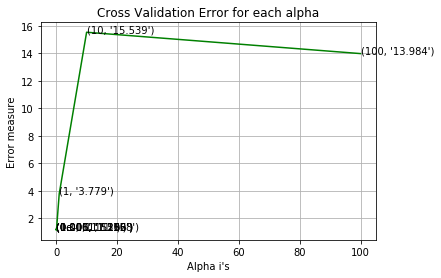

For values of best alpha =  0.1 The train log loss is: 0.4852678129889533
For values of best alpha =  0.1 The cross validation log loss is: 1.1524794599108654
For values of best alpha =  0.1 The test log loss is: 1.1537834008578556


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_responseCoding_SVD, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding_SVD, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding_SVD)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_responseCoding_SVD, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding_SVD, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding_SVD)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding_SVD)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding_SVD)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1524794599108654
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


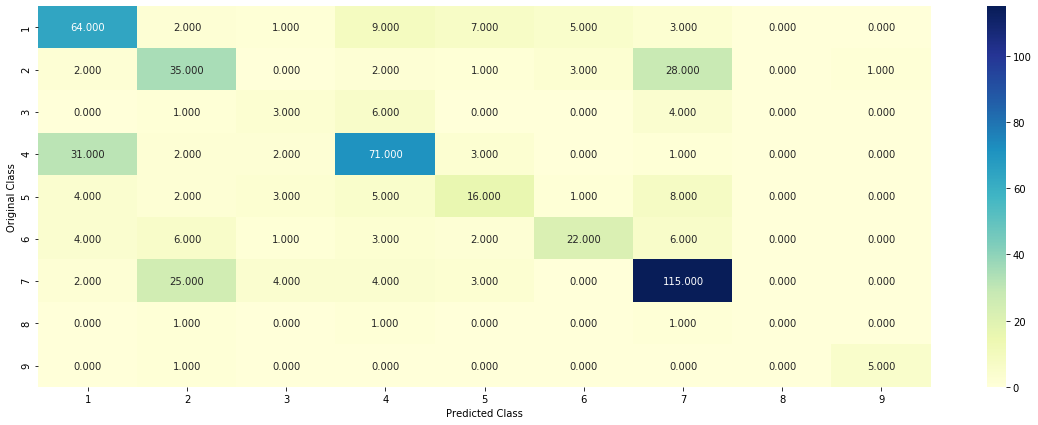

-------------------- Precision matrix (Columm Sum=1) --------------------


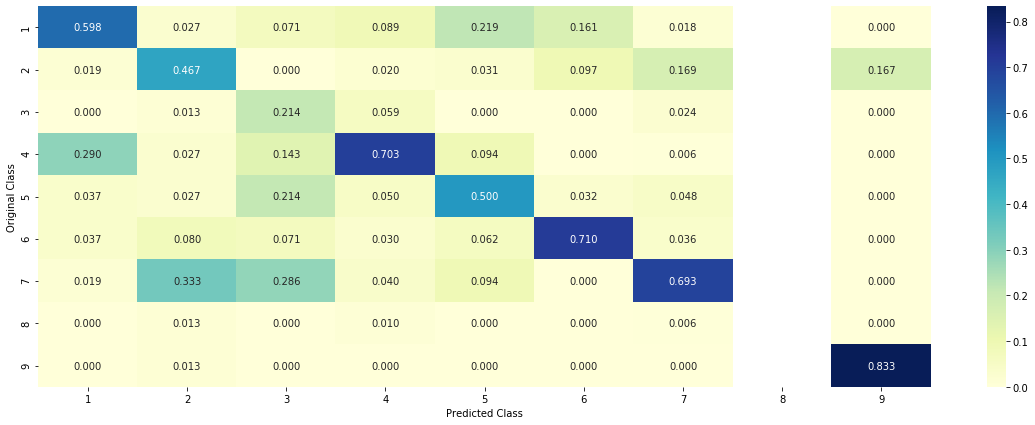

-------------------- Recall matrix (Row sum=1) --------------------


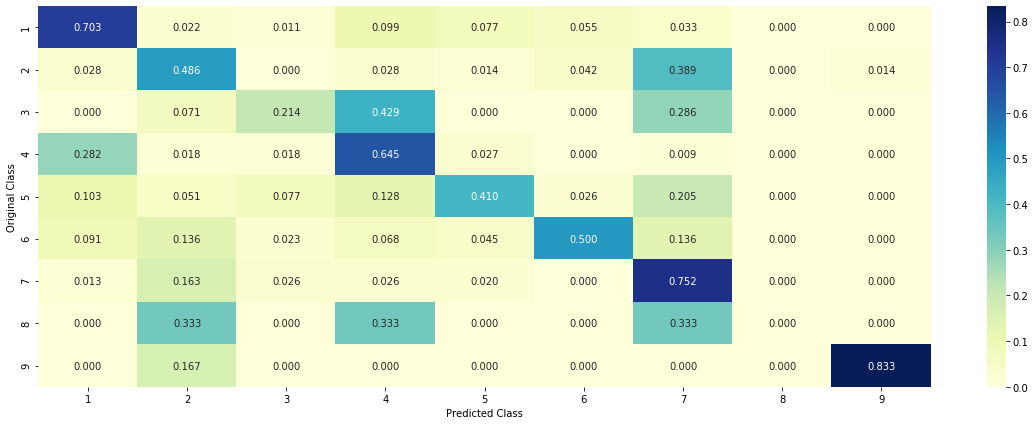

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding_SVD, train_y, cv_x_responseCoding_SVD, cv_y, clf)

In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_responseCoding_SVD,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_responseCoding_SVD[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding_SVD[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0],X_test['Text_lemmatized'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0387 0.6419 0.0037 0.0649 0.0858 0.0076 0.1461 0.0095 0.0018]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point


**CountVectorizer with unigrams and bigrams**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=5,ngram_range = (1,3),analyzer= clean_text) 
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text_lemmatized'])
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['Text_lemmatized'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Text_lemmatized'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
train_x_onehotCoding = hstack((Train_gene_hashed_features,Train_var_hashed_features,train_text_feature_onehotCoding)).tocsr()
train_y = np.array(y_train) 
test_x_onehotCoding = hstack((Test_gene_hashed_features,Test_var_hashed_features,test_text_feature_onehotCoding)).tocsr()
test_y = np.array(y_test) 
cv_x_onehotCoding = hstack((cv_gene_hashed_features,cv_var_hashed_features,cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(y_cv)

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 28365)
(number of data points * number of features) in test data =  (665, 28365)
(number of data points * number of features) in cross validation data = (532, 28365)


for alpha = 1e-06
Log Loss : 1.2683230310356768
for alpha = 1e-05
Log Loss : 1.254636494062953
for alpha = 0.0001
Log Loss : 1.2240393914908145
for alpha = 0.001
Log Loss : 1.2329255589703854
for alpha = 0.01
Log Loss : 1.277636107344121
for alpha = 0.1
Log Loss : 1.5041056239333954
for alpha = 1
Log Loss : 1.7328399769878255
for alpha = 10
Log Loss : 1.7621259036615398
for alpha = 100
Log Loss : 1.7649782387752748


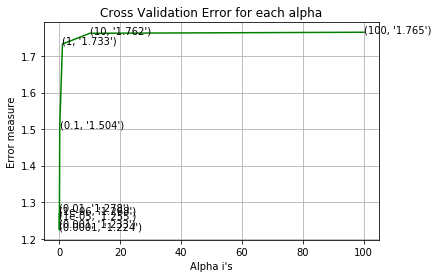

For values of best alpha =  0.0001 The train log loss is: 0.5534579799541123
For values of best alpha =  0.0001 The cross validation log loss is: 1.2240393914908145
For values of best alpha =  0.0001 The test log loss is: 1.1183711157010294


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2240393914908145
Number of mis-classified points : 0.39849624060150374
-------------------- Confusion matrix --------------------


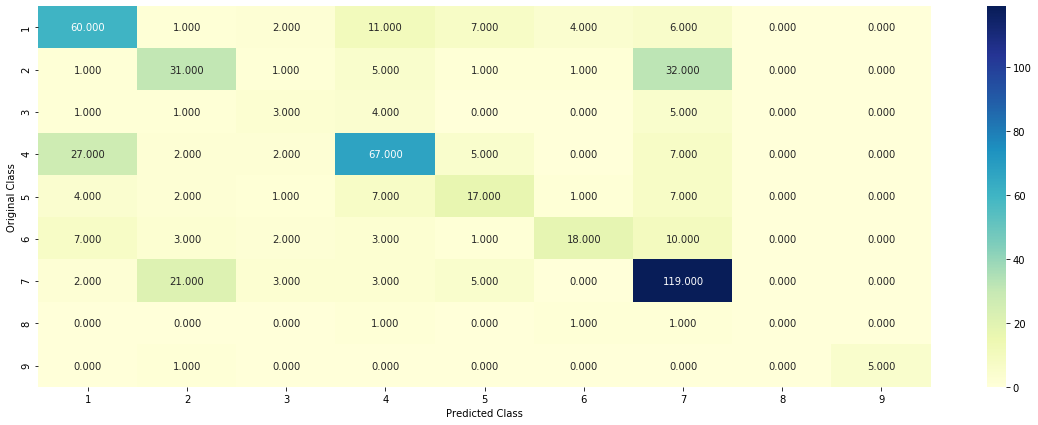

-------------------- Precision matrix (Columm Sum=1) --------------------


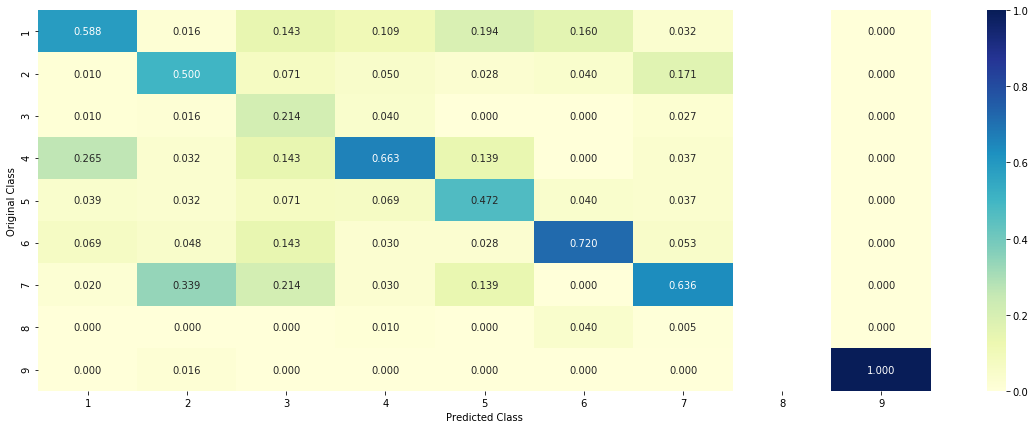

-------------------- Recall matrix (Row sum=1) --------------------


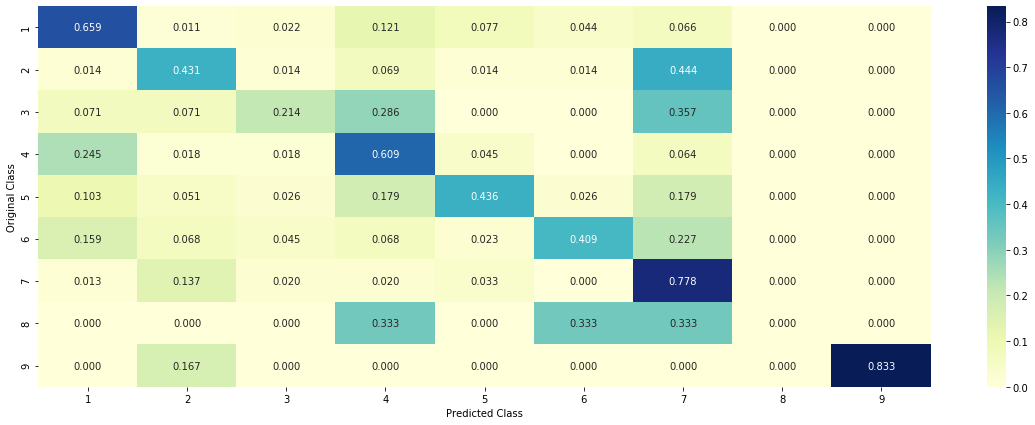

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding, cv_y, clf)

In [ ]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer(min_df=5,ngram_range = (1,3),analyzer= clean_text)
    var_count_vec =  CountVectorizer(min_df=5,ngram_range = (1,3),analyzer= clean_text)
    text_count_vec = CountVectorizer(min_df=5,ngram_range = (1,3),analyzer= clean_text) 
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text_lemmatized'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in str(text).split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0],X_test['Text_lemmatized'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[5.58e-02 7.50e-02 6.00e-04 5.52e-02 1.30e-03 5.60e-03 7.97e-01 7.00e-03
  2.60e-03]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point


**Performance**

In [ ]:
from prettytable import PrettyTable
from termcolor import colored
print(colored('Performance Table','green'))
x = PrettyTable()
x.field_names =["Models","Train","CV","Test","Misclassified(%)"]

x.add_row(["Naive Bayes (Response)",1.232760,1.364437,1.225307,0.45864])
x.add_row(["KNN (Response)", 0.548507,0.86434,0.643606,0.36842105]) 
x.add_row(["LR(Class balanced) one hot coding",0.55441,1.1980,1.12872,0.39849])
x.add_row(["Lr SVM one hot encoding",0.5873020,1.200037,1.128794,0.394736]) 
x.add_row(["Random Forest one hot coding",0.8639150,1.288255,1.22700,0.44172])
x.add_row(["Random Forest Response coding",0.03975291,1.848071,1.844432,0.712406])
x.add_row(["Stacking classifier",0.66170562,1.338146,1.17724,0.3684210])
x.add_row(["Maximum Voting Classifier",1.012613,1.218017,1.12291,0.36992])
x.add_row(["Gene+Var+Text with TFIDF+SVD",0.48526781,1.152479,1.1537834,0.3778195])
x.add_row(["LR(CountVectorizer with unigrams and bigrams)",0.5534579,1.224039,1.118371,0.39849])
print(x)

Performance Table
+-----------------------------------------------+------------+----------+-----------+------------------+
|                     Models                    |   Train    |    CV    |    Test   | Misclassified(%) |
+-----------------------------------------------+------------+----------+-----------+------------------+
|             Naive Bayes (Response)            |  1.23276   | 1.364437 |  1.225307 |     0.45864      |
|                 KNN (Response)                |  0.548507  | 0.86434  |  0.643606 |    0.36842105    |
|       LR(Class balanced) one hot coding       |  0.55441   |  1.198   |  1.12872  |     0.39849      |
|            Lr SVM one hot encoding            |  0.587302  | 1.200037 |  1.128794 |     0.394736     |
|          Random Forest one hot coding         |  0.863915  | 1.288255 |   1.227   |     0.44172      |
|         Random Forest Response coding         | 0.03975291 | 1.848071 |  1.844432 |     0.712406     |
|              Stacking classifier   